# min(DALL·E)

This is a fast, minimal port of Boris Dayma's [DALL·E Mini](https://github.com/borisdayma/dalle-mini) (with mega weights).  It has been stripped down for inference and converted to PyTorch.  The only third party dependencies are numpy, requests, pillow and torch.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
%cd /content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/generation

/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/generation


# Install Dependencies

In [25]:
!pip install min-dalle
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Winoground

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [26]:
def get_token():
    with open("../token.txt") as f:
        return f.read()

In [27]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
auth_token = get_token()
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

  0%|          | 0/1 [00:00<?, ?it/s]

# Load Model

Load the model parameters once and reuse the model to generate multiple images.

The required models will be downloaded to `models_root` if they are not already there.  Set the `dtype` to `torch.float16` to save GPU memory. `float32` is faster than `float16` but uses more GPU memory.  Change the `grid_size` to 3 or less if using `float32`. If you have an Ampere architecture GPU you can use `torch.bfloat16`.  Set the `device` to either "cuda" or "cpu".


In [28]:
import torch
from min_dalle import MinDalle

models_root = "/content/pretrained" #@param {type:"string"}
dtype = "float16" #@param ["float32", "float16", "bfloat16"]
device = "cuda" #@param ["cpu", "cuda"]
is_mega = True #@param {type:"boolean"}
is_reusable = True #@param {type:"boolean"}
is_verbose = True #@param {type:"boolean"}

model = MinDalle(
    models_root=models_root,
    dtype=getattr(torch, dtype),
    device=device,
    is_mega=is_mega, 
    is_reusable=is_reusable,
    is_verbose=is_verbose
)

using device cuda
intializing TextTokenizer
initializing DalleBartEncoder
initializing DalleBartDecoder
initializing VQGanDetokenizer


# Generate Images

Once everything has finished initializing, call `generate_image_stream` with some text as many times as you want. You can asjust input parameters to your needs.

## Basic

- `text`: For long prompts, only the first 64 tokens will be used to generate the image.

- `seed`: Use a positive seed for reproducible results.

- `grid_size`: Size of the image grid. Reduce this if you run out of GPU memory.

- `progressive_outputs`: Whether to show intermediate output.  Adds a small delay and increases memory usage.

- `is_seamless`: Tiles the images in token space instead of pixel space. This has the effect of blending the images at the borders.

## Advanced

- `temperature`: High temperature increases the probability of sampling low scoring image tokens.
- `top_k`: Each image token is sampled from the top-k scoring tokens.

Increasing `temperature` and/or `top_k` will increase variety in the generated images at the expense of the images being less coherent. Setting `temperature` high and `top_k` low can result in more variety without sacrificing coherence.

## Expert

- `supercondition_factor`: Higher values can result in better agreement with the text but a narrower variety of generated images. Let `logits_cond` be the logits computed from the text prompt and `logits_uncond` be the logits computed from an empty text prompt, and let `a` be the super-condition factor, then `logits = logits_cond * a + logits_uncond * (1 - a)`

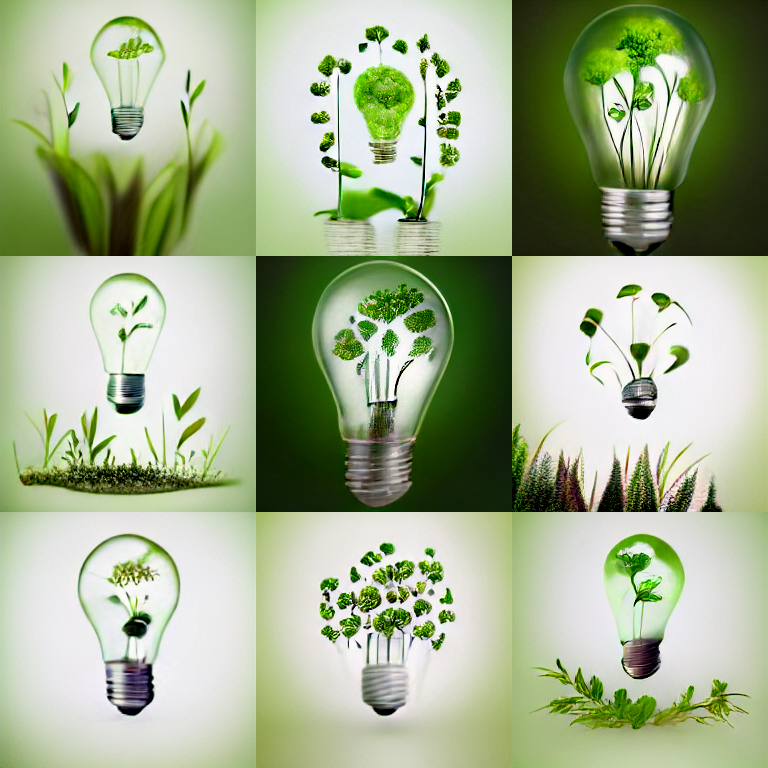

CPU times: user 27.6 s, sys: 408 ms, total: 28 s
Wall time: 30 s


In [29]:
from IPython.display import display, update_display

text = "some plants surrounding a lightbulb" #@param {type:"string"}
seed = 1 #@param {type:"integer"}
grid_size = 3 #@param {type:"slider", min:1, max:9, step:1}
progressive_outputs = True #@param {type:"boolean"}
is_seamless = False #@param {type:"boolean"}
temperature = 1 #@param {type:"slider", min:0.01, max:16, step:0.01}
top_k = 256 #@param [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
supercondition_factor = 16 #@param [4, 8, 16, 32, 64]
is_verbose = False #@param {type:"boolean"}

image_stream = model.generate_image_stream(
    text=text,
    seed=seed,
    grid_size=grid_size,
    progressive_outputs=progressive_outputs,
    is_seamless=is_seamless,
    temperature=temperature,
    top_k=int(top_k),
    supercondition_factor=float(supercondition_factor),
    is_verbose=is_verbose
)

is_first = True
for images in image_stream:
    display_image = display if is_first else update_display
    display_image(images, display_id=1)
    is_first = False

# Generate Winoground Images

Generate images from captions that appear in the Winoground paper.

In [90]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_example(id):
    print("caption_0:", winoground[id]["caption_0"])
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    print("caption_1:", winoground[id]["caption_1"])
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

def generate_images(text):
    images = model.generate_images(
        text=text,
        seed=seed,
        grid_size=grid_size,
        is_seamless=is_seamless,
        temperature=temperature,
        top_k=int(top_k),
        supercondition_factor=float(supercondition_factor),
        is_verbose=is_verbose
    )
    return images

def get_image_grid(imgs, size):
    assert len(imgs) == size*size

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(size*w, size*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i//size*h, i%size*w))
    return grid

def save_images(images, path, id, cap):
    images_np = images.to('cpu').numpy().astype(np.uint8)
    images_pil = []
    for i, image_np in enumerate(images_np):
        image = Image.fromarray(image_np)
        images_pil.append(image)
        image.save(f"{path}/ex_{id}_cap_{cap}_img_{i}.png")

    image_grid = get_image_grid(images_pil, grid_size)
    display(image_grid)
    image_grid.save(f"{path}/ex_{id}_cap_{cap}_img.png")

def generate_images_winoground(id, path):
    images_cap_0 = generate_images(winoground[id]["caption_0"])
    print("caption_0:", winoground[id]["caption_0"])
    save_images(images_cap_0, path, id, 0)

    images_cap_1 = generate_images(winoground[id]["caption_1"])
    print("caption_1:", winoground[id]["caption_1"])
    save_images(images_cap_1, path, id, 1)

## Example 14: there is [a mug] in [some grass]


caption_0: there is a mug in some grass
caption_1: there is some grass in a mug


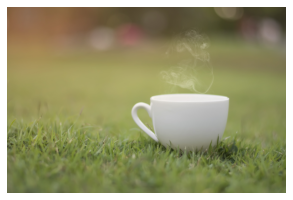

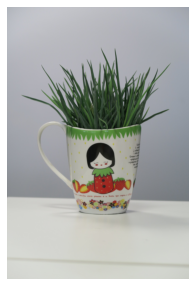

In [92]:
show_example(14)

In [93]:
path = "../images/min_dalle"
generate_images_winoground(14, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 21: a person [sits] and a dog [stands]

caption_0: a person sits and a dog stands
caption_1: a person stands and a dog sits


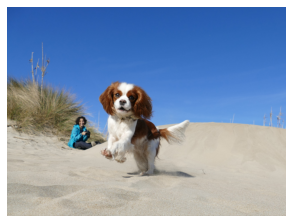

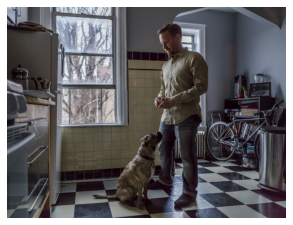

In [94]:
show_example(21)

In [95]:
generate_images_winoground(21, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 27: the person with the ponytail [packs] stuff and other [buys] it


caption_0: the person with the ponytail packs stuff and other buys it
caption_1: the person with the ponytail buys stuff and other packs it


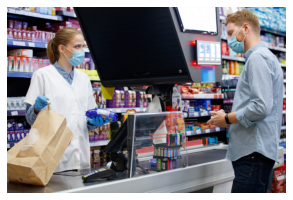

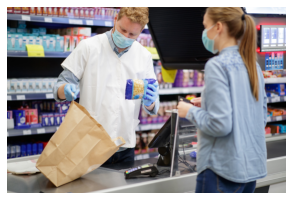

In [96]:
show_example(27)

In [97]:
generate_images_winoground(27, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 29: a [brown] dog is on a [white] couch

caption_0: a brown dog is on a white couch
caption_1: a white dog is on a brown couch


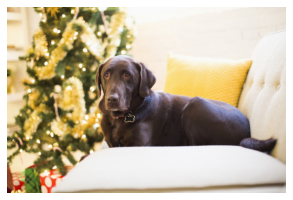

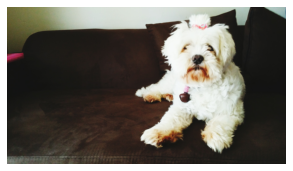

In [98]:
show_example(29)

In [99]:
generate_images_winoground(29, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 61: there are [three] people and [two] windows

caption_0: there are three people and two windows
caption_1: there are two people and three windows


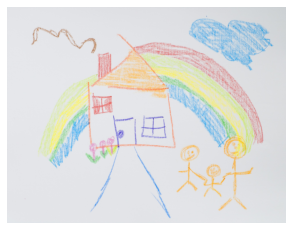

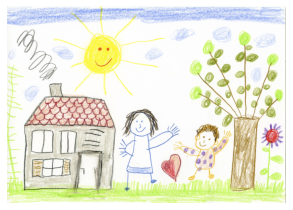

In [100]:
show_example(61)

In [101]:
generate_images_winoground(61, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 72: it’s a [truck] [fire]

caption_0: it's a fire truck
caption_1: it's a truck fire


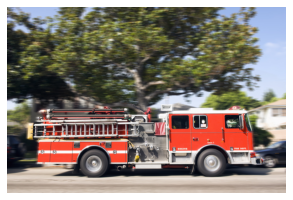

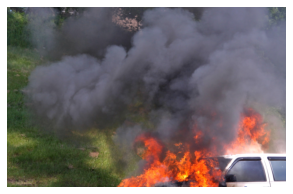

In [102]:
show_example(72)

In [103]:
generate_images_winoground(72, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 75:  the kid [with the magnifying glass] looks at them []

caption_0: the kid with the magnifying glass looks at them
caption_1: the kid looks at them with the magnifying glass


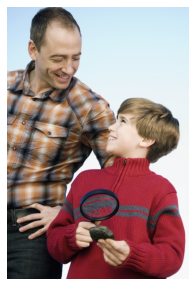

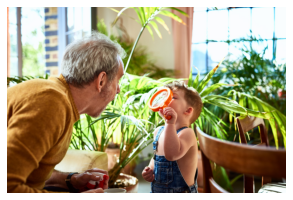

In [104]:
show_example(75)

In [105]:
generate_images_winoground(75, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 118: [circular] food on [heart-shaped] wood

caption_0: circular food on heart-shaped wood
caption_1: heart-shaped food on circular wood


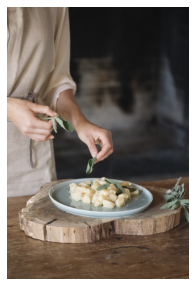

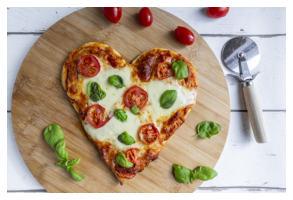

In [106]:
show_example(118)

In [107]:
generate_images_winoground(118, path)

Output hidden; open in https://colab.research.google.com to view.

## Example 155: [some plants] surrounding [a lightbulb]

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


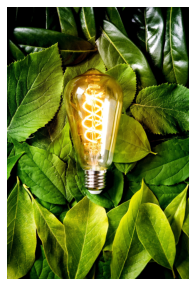

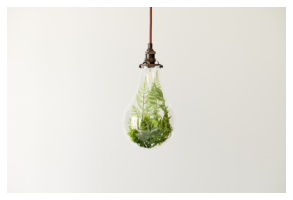

In [108]:
show_example(155)

In [109]:
generate_images_winoground(155, path)

Output hidden; open in https://colab.research.google.com to view.